# Simulation of Transcription as Coin Toss
## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).

2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.

3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, and 3.


In [ ]:
# For Instalations

%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.11.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Plots Distributions"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.11.1 on the current Colab Runtime...
2024-11-26 14:30:36 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.1-linux-x86_64.tar.gz [254553793/254553793] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package Plots...
Installing Julia package Distributions...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.11

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.11.1
Commit 8f5b7ca12ad (2024-10-16 10:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


# Simulate transcription as a Poisson process

Rate of transcription, lambda = 2

Total time, T = 10



In [2]:
# Inputs for simulations

# Rate of transcription
lambda = 2.0

# Total time
T = 10.0

# Initial number of mRNA
mRNA_0 = 0

# Total number of independent simulations
N = 1000

1000

In [3]:
# Call the packages
using Distributions
using Plots

In [4]:
# Function to simulate a Poisson process

# Inputs:
# lambda: Rate of the process. Float64
# T: Total time for simulation. Float64
# x0: Initial count. Int

# Outputs:
# event_times: A vector listing time points of events
# event_counts: A vector listing cumulative count of events for each time point in event_times

function simulate_poisson(lambda::Float64, T::Float64, x0::Int)
    event_times = [0.0]   # To store the time of each event
    event_counts = [x0]      # To store the cumulative event count
    current_time = 0.0
    count = x0

    while current_time < T
        # Generate inter-arrival time from an exponential distribution
        inter_event_time = rand(Exponential(1 / lambda))

        # Update clock
        current_time += inter_event_time

        # Check if current_time is still within the desired time limit
        if current_time <= T
            count += 1                     # Increment the count of events
            push!(event_times, current_time)  # Record the time of the event
            push!(event_counts, count)      # Record the cumulative count
        end
    end

    return event_times, event_counts
end

simulate_poisson (generic function with 1 method)

In [5]:
# Do one simulation
t, mRNA_count = simulate_poisson(lambda, T, mRNA_0);


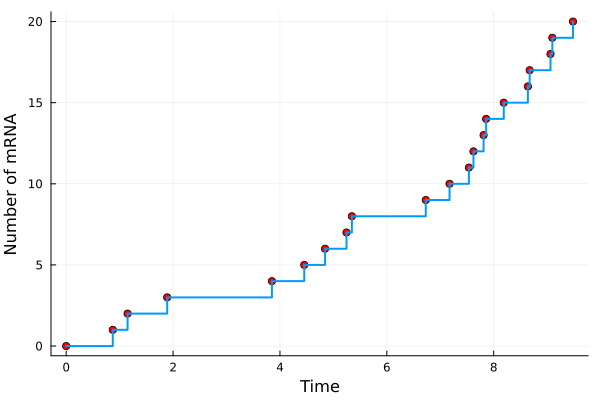

In [6]:
#Plot the data
plot(t, mRNA_count,
    xlabel="Time", ylabel="Number of mRNA",
    scatter=:auto, marker=:circle, markercolor=:red,
    lw=2, line=:steppost,
    legend=:none)


In [7]:
# Function to bin simulation data

# Inputs:
# time_data: A vector with event times. Float64
# count_data: A vector listing cumlative counts at time points in time_data. Int
# init_count: Initial count. Int
# total_T: Total time of simulation. Float64
# dt: Small interval for binning the data. Float64

#Outputs:
# time_bins: A vector with total time divided at small equal intervals. Float64
# binned_data: Vector for binned data as per the time_bins. Int

function data_binning(time_data::Vector{Float64}, count_data::Vector{Int}, init_count::Int, total_T::Float64, dt::Float64)
    time_bins = 0.0:dt:total_T
    binned_data = zeros(length(time_bins))
    binned_data[1] = init_count

    for j in 2:length(time_bins)
        idx = findlast(x -> x <= time_bins[j], time_data)
        binned_data[j] = count_data[idx]
    end

    return time_bins, binned_data
end


data_binning (generic function with 1 method)

In [8]:
# Doing multiple simulations

# Small time interval used for binning of data
dt = 0.1

# Creat time bins, vector to store average data
time_bins = 0.0:dt:T
avg_data = zeros(Float64, length(time_bins))
all_binned_data = zeros(Float64, length(time_bins), N)

# Do the independent simulations one-by-one
for j in 1:N

    # Simulate
    t, mRNA_count = simulate_poisson(lambda, T, mRNA_0)

    # Bin the data
    time_bins, binned_data = data_binning(t, mRNA_count, mRNA_0, T, dt)

    # Add to avg data
    avg_data += binned_data

    all_binned_data[:,j] = binned_data

end

# Average the data
avg_data = sum(all_binned_data, dims=2) ./ N;



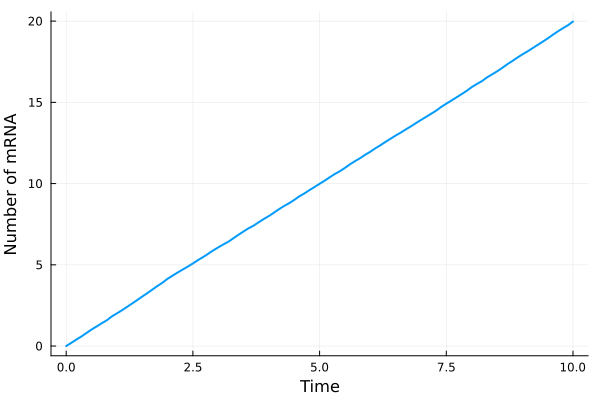

In [9]:

#Plot the average data
plot(time_bins, avg_data,
    xlabel="Time", ylabel="Number of mRNA",
    lw=2,
    legend=:none)


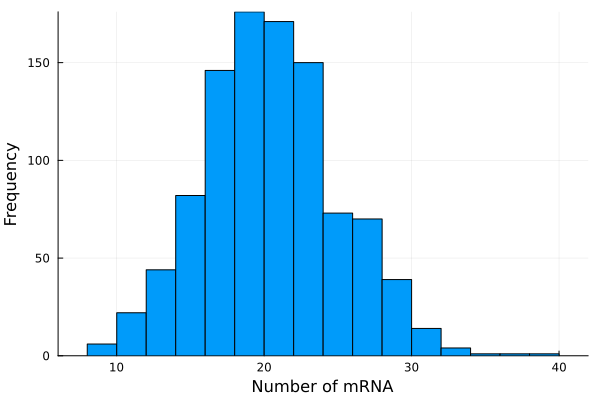

In [10]:
# Plot histogram to show distribution of mRNA in cells at the end

# Extract the last row
final_mRNA = all_binned_data[end, :]

# Plot the histogram
histogram(final_mRNA, bins=20,  xlabel="Number of mRNA", ylabel="Frequency", legend=:none)
